# 1) Imports

In [8]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [9]:
from os import walk
from os.path import join, exists
from utils import nomes, save_dataframe_as_feather, decode_rle

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, OPTICS, KMeans, AgglomerativeClustering, cluster_optics_dbscan

import tensorflow
from tensorflow.keras.preprocessing import image

# 2) Carregar dataset

In [11]:
dataset = pd.read_feather('train_com_imagens.feather')
dataset = dataset.sample(frac=1)
dataset

,id,class,segmentation,image,width,height
34498,case41_day25_slice_0001,stomach,None,.\train\case41\case41_day25\scans\slice_0001_2...,266,266
61065,case36_day16_slice_0002,large_bowel,None,.\train\case36\case36_day16\scans\slice_0002_2...,266,266
60690,case147_day18_slice_0083,small_bowel,20389 6 20653 10 20918 12 21183 13 21449 14 21...,.\train\case147\case147_day18\scans\slice_0083...,266,266
51303,case81_day0_slice_0043,large_bowel,None,.\train\case81\case81_day0\scans\slice_0043_26...,266,266
54533,case89_day0_slice_0109,large_bowel,41504 17 41862 20 42222 23 42581 28 42941 29 4...,.\train\case89\case89_day0\scans\slice_0109_36...,360,310
...,...,...,...,...,...,...
32985,case133_day0_slice_0100,stomach,None,.\train\case133\case133_day0\scans\slice_0100_...,360,310
11835,case80_day10_slice_0038,small_bowel,None,.\train\case80\case80_day10\scans\slice_0038_2...,266,266
29142,case2_day2_slice_0050,large_bowel,None,.\train\case2\case2_day2\scans\slice_0050_266_...,266,266
26663,case129_day20_slice_0098,small_bowel,39385 16 39742 21 40100 26 40459 32 40818 41 4...,.\train\case129\case129_day20\scans\slice_0098...,360,310


# 3) Clusterizar imagens p/ gerar exemplos de teste

In [139]:
distancia_vizinho = 50
n_vizinhos = 100
max_clusters = 35

def new_cluster_model(image_as_arr):
	# Demora menos mas consumo de memória é n
	# return DBSCAN(
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# ).fit_predict(image_as_arr)

	return KMeans(
		n_clusters=max_clusters,
	).fit_predict(image_as_arr)

	# Demora consideravelmente mas não consome tanta memória
	# return OPTICS(
	# 	cluster_method='dbscan',
	# 	eps=distancia_vizinho,
	# 	min_samples=n_vizinhos,
	# 	n_jobs=-2
	# ).fit_predict(image_as_arr)

	# Demora + consumo de memória
	# return AgglomerativeClustering(
	# 	n_clusters=10,
	# ).fit_predict(image_as_arr)

In [150]:
class Counter:
    _count = 0
    @staticmethod
    def get():
        Counter._count += 1
        return Counter._count
    
    @staticmethod
    def reset():
        Counter._count = 0


def clustering(linha, redimensionar=False):
    largura, altura = linha['width'], linha['height']
    # largura, altura = 100, 100

    img = image.load_img(
        linha['image'],
        target_size=(largura, altura),
        color_mode='grayscale'
    )

    # Para realizar o clustering de uma imagem
    # Precisa de uma matriz das posicoes + uma dimensao para cores
    image_as_arr = image.img_to_array(img).reshape(largura * altura, 1)

    print(Counter.get(), end=', ')
    
    # Rodar clustering
    cluster_array = new_cluster_model(image_as_arr)

    if not redimensionar:
        return cluster_array

    cluster_array = cluster_array.reshape(largura, altura)
    cluster_array = np.expand_dims(cluster_array, axis=2)
    cluster_img_raw = image.array_to_img(cluster_array)
    cluster_img_raw.save('cluster.png')

    # Abrir cluster novamente para redimensionar
    cluster_img = image.load_img(
        'cluster.png',
        target_size=(largura, altura),
        color_mode='grayscale'
    )
    # linha['cluster_width'] = largura
    # linha['cluster_height'] = altura
    linha.loc['cluster_width'] = largura

    return image.img_to_array(cluster_img).reshape(largura * altura, 1)

In [195]:
# Limitar os dados por questão de tempo
# limite_dados = 10000
# limite_dados = 1000
# limite_dados = 100
limite_dados = 25
# limite_dados = 5
# limite_dados = 1

df_dados = pd.concat([
	dataset[dataset['class'] == 'stomach'].sample(limite_dados),
	dataset[dataset['class'] == 'small_bowel'].sample(limite_dados),
	dataset[dataset['class'] == 'large_bowel'].sample(limite_dados),
])

df_dados['class'].value_counts()

df_dados['clusters'] = df_dados.apply(clustering, axis=1)
df_dados.head()

26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 

,id,class,segmentation,image,width,height,clusters
14773,case136_day27_slice_0018,stomach,None,.\train\case136\case136_day27\scans\slice_0018...,360,310,"[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2..."
63427,case145_day19_slice_0112,stomach,None,.\train\case145\case145_day19\scans\slice_0112...,360,310,"[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1..."
18821,case144_day14_slice_0006,stomach,None,.\train\case144\case144_day14\scans\slice_0006...,266,266,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
14734,case129_day24_slice_0007,stomach,None,.\train\case129\case129_day24\scans\slice_0007...,360,310,"[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."
21933,case143_day0_slice_0123,stomach,None,.\train\case143\case143_day0\scans\slice_0123_...,266,266,"[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1..."


## Visualização

In [152]:
linha = df_dados[df_dados['segmentation'].notnull()].sample(n=1).iloc[0]
largura, altura = linha['width'], linha['height']

print('Número clusters:', pd.DataFrame(linha['clusters']).value_counts().keys().shape)
print('Tem segmentação:', bool(linha['segmentation']))

Número clusters: (35,)
Tem segmentação: True


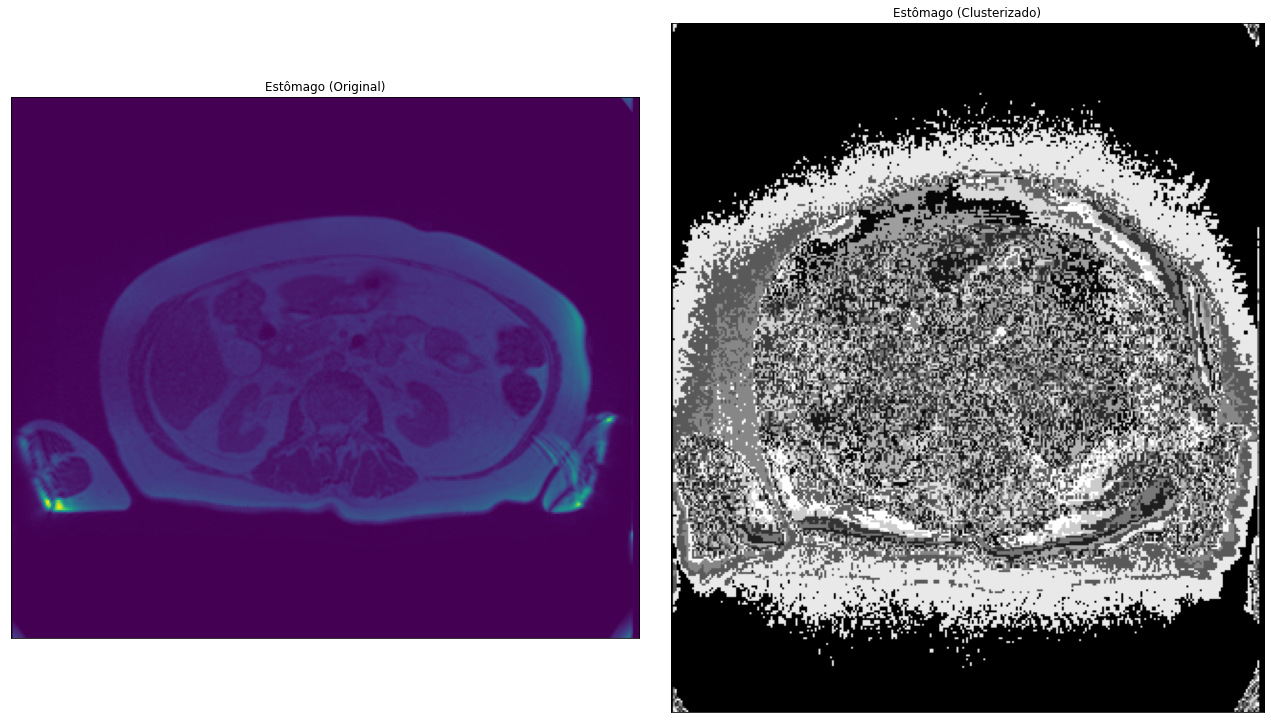

In [153]:
fig = plt.figure(figsize=(18, 10))
fig.patch.set_alpha(1)

# Desenho original
ax = plt.subplot(1, 2, 1)
ax.imshow(plt.imread(linha['image']))
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Original)')

# Desenhar todos os clusters juntos
ax = plt.subplot(1, 2, 2)

altura, largura = plt.imread(linha['image']).shape

clusters = linha['clusters'].reshape(largura, altura)
ax.imshow(clusters, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title(nomes[linha['class']] + ' (Clusterizado)')
plt.tight_layout()

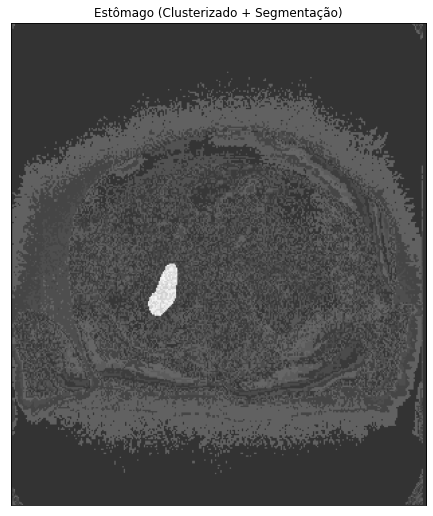

In [156]:
# Desenhar todos os clusters juntos + segmentação
fig = plt.figure(figsize=(18, 10))
fig.patch.set_alpha(1)
if linha['segmentation']:
	ax = plt.subplot(1, 3, 3)

	ax.imshow(clusters, cmap='gray', alpha=0.5)

	segmentation = linha['segmentation']
	segmentation_rle = decode_rle(segmentation, shape=(altura, largura))

	ax.imshow(
		segmentation_rle,
		cmap='gray',
		alpha=0.6
	)
	plt.xticks([])
	plt.yticks([])
	plt.title(nomes[linha['class']] + ' (Clusterizado + Segmentação)')

	plt.tight_layout()

plt.show()

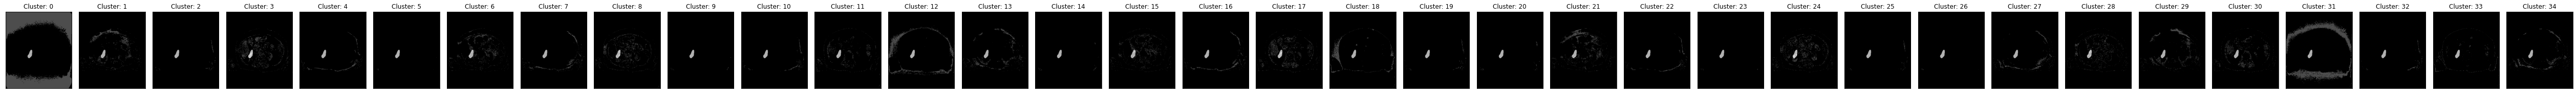

In [157]:
# Desenhar clusters separados + segmentação
fig, axs = plt.subplots(1, max_clusters, figsize=(max_clusters * 2, 6))
fig.patch.set_alpha(1)
for i in range(max_clusters):
	cluster_selecionado = i
	d = pd.DataFrame(linha['clusters']).applymap(lambda x: 1 if x == cluster_selecionado else 0)
	d = np.array(d.values).reshape(largura, altura)

	axs[i].imshow(d, cmap='gray')
	axs[i].imshow(segmentation_rle, cmap='gray', alpha=0.7)
	axs[i].set_title(f'Cluster: {cluster_selecionado}')
	axs[i].set_xticks([])
	axs[i].set_yticks([])

plt.tight_layout()

# 4) Separar clusters em imagens por pasta

## Visualização do cluster com mais pixels na interseção

In [206]:
def comparar_cluster_linha(linha):
	largura, altura = linha['width'], linha['height']
	clusters = linha['clusters']
	segmentation = decode_rle(linha['segmentation'], shape=(altura, largura))

	# Transformar de matriz 2d para vetor 1d
	segmentation = segmentation.reshape(1, -1)

	# Pegar apenas os clusters que estão na segmentação
	clusters_segmentacao = clusters * segmentation
	clusters_selecionados = np.unique(clusters_segmentacao)

	# Contar quantos clusters existem na segmentação
	clusters_contagem = [
		[i, np.count_nonzero(clusters_segmentacao == i)]
		for i in clusters_selecionados
	]
	clusters_contagem = sorted(clusters_contagem, key=lambda x: x[1], reverse=True)
	print(clusters_contagem)

	# Retornar, de fato, o que tiver maior quantia ou o segundo maior para tentar ignorar o cluster que
	# seleciona o fundo?
	# melhor_cluster = clusters_contagem[0]
	if len(clusters_contagem) > 1:
		melhor_cluster = clusters_contagem[1]
	else:
		melhor_cluster = clusters_contagem[0]

	# Além disso, retornar um ou mais clusters que tiverem o mesmo score de pixels ou
	# retornar todos os que tiveram interseção?

	numero_cluster, _quantia = melhor_cluster
	return numero_cluster


In [207]:
# Buscar linha aleatória
linha = df_dados[df_dados['segmentation'].notnull()].sample(n=1).iloc[0]
melhor = comparar_cluster_linha(linha)
print('Melhor cluster:', melhor)


[[0, 111341], [2, 44], [24, 34], [12, 31], [13, 27], [31, 27], [22, 24], [26, 20], [34, 18], [5, 14], [17, 13], [1, 4], [9, 3]]
Melhor cluster: 2


In [208]:
def desenhar_cluster(i):
	# Deixar fundo branco
	f = plt.figure(figsize=(5, 5))
	f.patch.set_alpha(1)

	# Desenhar clusters de categoria I
	plt.imshow(
		(linha['clusters'] == i).reshape(linha['width'], linha['height']),
		cmap='gray' if i != melhor else 'hot',
	)

	# Desenhar segmentação
	plt.imshow(
		decode_rle(linha['segmentation'],
		shape=(linha['height'], linha['width'])),
		alpha=0.5,
		cmap='gray'
	)

	# Titulo + Remover texto de eixo
	plt.title(f'Cluster {i} - {nomes[linha["class"]]}')
	plt.xticks([])
	plt.yticks([])
	plt.show()

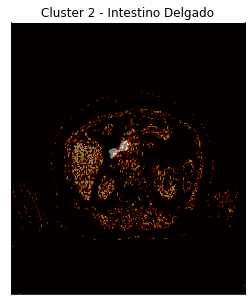

In [209]:
desenhar_cluster(melhor)

# for i in np.unique(linha['clusters']):
# 	if i == melhor:
# 		continue
# 	desenhar_cluster(i)

## Criação das pastas

In [185]:
!mkdir "clusters"
!mkdir "clusters/stomach"
!mkdir "clusters/large_bowel"
!mkdir "clusters/small_bowel"
!mkdir "clusters/null"

A subdirectory or file clusters already exists.


In [224]:
def salvar_clusters(linha):
	if 'clusters' not in linha:
		return

	melhor_cluster = comparar_cluster_linha(linha)
	# print('Melhor cluster:', melhor_cluster)

	# Salvar imagem
	melhor_cluster_arr = linha['clusters'] == melhor_cluster
	melhor_cluster_arr = melhor_cluster_arr.reshape(linha['width'], linha['height'])
	plt.imsave(
		fname='clusters/{}/{}_{}.png'.format(linha['class'], melhor_cluster, linha['id']),
		arr=melhor_cluster_arr,	
		cmap='gray'
	)

	for i in np.unique(linha['clusters']):
		if i == melhor_cluster:
			continue

		cluster_arr = linha['clusters'] == i
		cluster_arr = cluster_arr.reshape(linha['width'], linha['height'])
		plt.imsave(
			fname='clusters/null/{}_{}.png'.format(i, linha['id']),
			arr=cluster_arr,	
			cmap='gray'
		)


In [225]:
df_dados.apply(lambda x: salvar_clusters(x), axis=1)

[[0, 111600]]
[[0, 111600]]
[[0, 70756]]
[[0, 111600]]
[[0, 70756]]
[[0, 111600]]
[[0, 70756]]
[[0, 69690], [10, 138], [28, 126], [33, 99], [13, 95], [19, 80], [4, 63], [1, 56], [21, 50], [18, 35], [25, 35], [11, 27], [22, 27], [34, 26], [7, 24], [31, 23], [32, 22], [30, 21], [16, 20], [3, 19], [8, 19], [12, 17], [26, 17], [14, 13], [6, 10], [15, 4]]
[[0, 70756]]
[[0, 109119], [27, 223], [9, 222], [25, 221], [20, 217], [2, 207], [32, 206], [18, 184], [1, 181], [12, 174], [14, 144], [21, 111], [29, 107], [3, 89], [16, 76], [17, 38], [6, 34], [5, 30], [19, 12], [26, 3], [30, 2]]
[[0, 70756]]
[[0, 70756]]
[[0, 111600]]
[[0, 70756]]
[[0, 70756]]
[[0, 111600]]
[[0, 70756]]
[[0, 111600]]
[[0, 70756]]
[[0, 111600]]
[[0, 111600]]
[[0, 70702], [28, 20], [18, 8], [12, 7], [31, 4], [5, 3], [19, 3], [14, 2], [6, 1], [7, 1], [10, 1], [17, 1], [22, 1], [29, 1], [34, 1]]
[[0, 70756]]
[[0, 70756]]
[[0, 111600]]
[[0, 111600]]
[[0, 66168], [26, 363], [16, 259], [1, 254], [27, 254], [15, 219], [12, 211],

14773    None
63427    None
18821    None
14734    None
21933    None
         ... 
73549    None
81853    None
60815    None
97751    None
31231    None
Length: 75, dtype: object

In [ ]:
# save_dataframe_as_feather(df_dados, 'train_imagens_clusters.feather')